<a href="https://colab.research.google.com/github/perfectpanda-works/machine-learning/blob/master/TRANSFER_LEARNING_FOR_COMPUTER_VISION_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 訓練データはデータ拡張してNormalizeを行う。
# 検証データにはNormalizeのみをかける。
data_transforms = {
    'train': transforms.Compose([
        #ランダムなサイズ、                         
        transforms.RandomResizedCrop(224),
        #50:50の確率で水平に反転
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/My Drive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

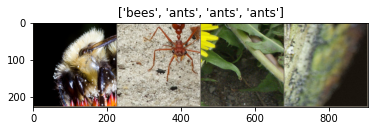

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

##モデルを訓練する

In [ ]:
#訓練の関数を定義
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #エポックループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #それぞれのエポックで訓練データで訓練→検証データで検証
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()   # モデルを検証モードに

            #各種変数の初期化
            running_loss = 0.0
            running_corrects = 0

            #データローダーからミニバッチを読み込むループ
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #勾配を初期化
                optimizer.zero_grad()

                #順伝播
                #※1:訓練データの時はテンソルの勾配を求める
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #訓練データの時に逆伝播＋重みの更新を行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #損失等を計算する
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #学習率の更新を行う
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #検証データで精度が以前より高ければモデルをdeepcopyする
            if phase == 'val' and epoch_acc > best_acc:
                #ベストの精度を更新
                best_acc = epoch_acc
                #モデルのコピーを保存して「best_model_wts」に格納
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    #１エポック終了毎の表示
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #最も良いモデルを読みだして返す
    model.load_state_dict(best_model_wts)
    return model

※1:

「with torch.set_grad_enabled(phase == 'train'):」
は、torch.set_grad_enabled(True)だと自動微分をオンにして勾配を求める設定となるので、(phase=='train')とすることで訓練データのときにTrueとなり、訓練データをいれたときに勾配を求めつつ順伝播を行う設定となる。

In [ ]:
#モデルの検証データでの結果を6枚だけ可視化する関数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

訓練済みモデルをロードして今回のモデルに組み込みます

事前学習モデルは。「ResNet18」を利用するようです。

https://jp.mathworks.com/help/deeplearning/ref/resnet18.html


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 今回は出力層の分類数は２に固定で設定
# 「nn.Linear(num_ftrs, len(class_names))」のように識別クラス数を与えることもできます。
model_ft.fc = nn.Linear(num_ftrs, 2)

#デバイスの指定を行います
model_ft = model_ft.to(device)

#損失関数を設定します。交差クロスエントロピーを利用します。
criterion = nn.CrossEntropyLoss()

#最適化手法をMomentumSGDに設定します。
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# ７エポック毎に学習率を0.1減衰させる「StepLR」です。
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6049 Acc: 0.7500
val Loss: 0.4479 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4446 Acc: 0.8156
val Loss: 0.6298 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.5125 Acc: 0.7664
val Loss: 0.2022 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.6354 Acc: 0.7541
val Loss: 0.3502 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.3900 Acc: 0.8197
val Loss: 0.4083 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.6051 Acc: 0.7992
val Loss: 0.3120 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5180 Acc: 0.8320
val Loss: 0.2723 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3050 Acc: 0.8607
val Loss: 0.2255 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3307 Acc: 0.8607
val Loss: 0.2398 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2960 Acc: 0.8730
val Loss: 0.2421 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2494 Acc: 0.8770
val Loss: 0.2651 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2826 Acc: 0.8689
val Loss: 0.2148 Acc: 0.9346

Ep

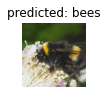

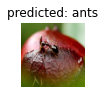

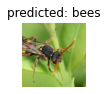

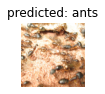

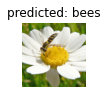

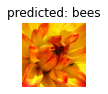

In [ ]:
visualize_model(model_ft)